In [1]:
import pqr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prices = pd.read_csv("./data/moex_prices.csv", index_col="Date", parse_dates=True)
prices.tail()

,ABRD,ACKO,AESL,AFKS,AFLT,AKHA,AKRN,ALBK,ALNU,ALRS,...,TCSG,VKCO,AGRO,QIWI,FIVE.1,POLY,YNDX,POGR,VEON-RX,RAVN
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-07,183.5,NaN,NaN,13.622,37.58,NaN,20910.0,NaN,NaN,92.80,...,3470.0,492.0,1001.2,442.0,1275.5,904.6,2130.0,12.300,83.60,NaN
2022-04-08,180.0,NaN,NaN,13.213,36.94,NaN,20160.0,NaN,NaN,82.53,...,3274.5,497.8,1006.0,432.5,1257.0,904.1,2115.0,11.855,82.55,NaN
2022-04-11,178.0,NaN,NaN,13.200,35.46,NaN,19676.0,NaN,NaN,79.55,...,3269.0,488.0,1003.2,430.0,1234.0,925.0,2097.0,12.430,82.50,NaN
2022-04-12,175.5,NaN,NaN,13.044,34.06,NaN,19298.0,NaN,NaN,78.46,...,3217.0,468.8,993.6,414.5,1187.0,936.7,2074.0,12.210,80.80,NaN
2022-04-13,177.5,NaN,NaN,13.200,33.86,NaN,19750.0,NaN,NaN,79.95,...,3172.0,466.8,955.0,412.5,1148.0,918.7,2088.0,12.110,75.00,NaN


In [3]:
def ew_momentum_portfolio(
    prices: pd.DataFrame,
    min_price: float = 10,
    look_back_period: int = 3,
    lag_period: int = 1,
    hold_period: int = 3,
    min_q: float = 0.7, 
    max_q: float = 1,
) -> pd.Series:
    return pqr.compose(
        pqr.freeze(pqr.filter, universe=prices > 100),
        pqr.freeze(pqr.look_back, period=look_back_period, agg="pct"),
        pqr.freeze(pqr.lag, period=lag_period),
        pqr.freeze(pqr.hold, period=hold_period),
        pqr.freeze(pqr.quantiles, min_q=min_q, max_q=max_q),
        pqr.ew,
        pqr.freeze(pqr.evaluate, universe_returns=pqr.to_returns(prices)),
    )(prices)


losers = ew_momentum_portfolio(prices, min_q=0, max_q=1/3)
neutral = ew_momentum_portfolio(prices, min_q=1/3, max_q=2/3)
winners = ew_momentum_portfolio(prices, min_q=2/3, max_q=1)

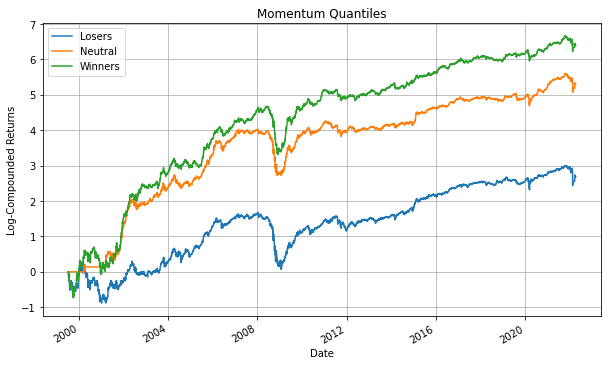

In [4]:
def log_compounded(r: pd.Series) -> pd.Series:
    compounded = (1 + r).cumprod()
    return np.log(compounded)

plt.figure(figsize=(10, 6))

log_compounded(losers).plot(label="Losers")
log_compounded(neutral).plot(label="Neutral")
log_compounded(winners).plot(label="Winners")

plt.title("Momentum Quantiles")
plt.xlabel("Date")
plt.ylabel("Log-Compounded Returns")
plt.grid()
plt.legend();

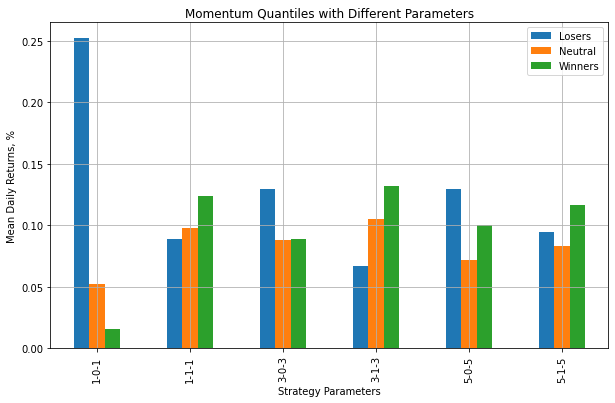

In [5]:
grid_mean = {}

for look_back in (1, 3, 5):
    for lag in (0, 1):
        
        returns = []
        for (min_q, max_q) in ((0, 1/3), (1/3, 2/3), (2/3, 1)):
            returns.append(
                ew_momentum_portfolio(
                    prices, 
                    look_back_period=look_back,
                    lag_period=lag,
                    hold_period=look_back,
                    min_q=min_q, 
                    max_q=max_q,
                )
            )
            
        grid_mean[f"{look_back}-{lag}-{look_back}"] = list(map(pd.Series.mean, returns))
        
grid_mean_df = pd.DataFrame(grid_mean).T
grid_mean_df.columns = ["Losers", "Neutral", "Winners"]
grid_mean_df *= 100

grid_mean_df.plot.bar(
    title="Momentum Quantiles with Different Parameters",
    ylabel="Mean Daily Returns, %",
    xlabel="Strategy Parameters",
    grid=True,
    legend=True,
    figsize=(10, 6),
);